In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams.update({'font.size': 22})
sns.set_style('whitegrid')

In [ ]:
IMG_DIR = 'report/img'
def save_pic(name):
    plt.tight_layout()
    plt.savefig(os.path.join(IMG_DIR, name))

In [ ]:
interestng_columns = ['person_id', 'person_name', 'year', 'office_id',
           'office_name', 'income']

In [ ]:
declarations_df = pd.read_csv('data/declarations.csv')[interestng_columns]
declarations_df.head()

In [ ]:
declarations_df.sample(5)

In [ ]:
declarations_df.shape

In [ ]:
declarations_df['office_name_sep'] = declarations_df.office_name.apply(lambda x: x.replace(' ', '\n')) # For plotting

In [ ]:
office_names = declarations_df[['office_id', 'office_name']].drop_duplicates().reset_index(drop=True)
office_names.index = office_names.office_id
office_names = office_names.drop(['office_id'], axis=1)
office_names

In [ ]:
office_names_sep = declarations_df[['office_id', 'office_name_sep']].drop_duplicates().reset_index(drop=True)
office_names_sep.index = office_names_sep.office_id
office_names_sep = office_names_sep.drop(['office_id'], axis=1)
office_names_sep

# Plan
## Meta
* Total declarations
* Declarations by year
* Declarations by office

## Basic info 
* Total people
* Total offices
* People distribution by years
* People distribution by office
* People distribution by years by office

## Declared assets
* Income, distributions
    * By year
* Richest people by year
    * Top 10 richest people in each year
* Median incomes by office
* Income vs years worked


# Meta

In [ ]:
print(declarations_df.shape)

In [ ]:
dec_count = declarations_df.groupby(['year'])['person_id'].count()
plt.figure(figsize=(15, 7))
sns.barplot(dec_count.index, dec_count)
plt.ylabel('Total declarations')
save_pic('total_dec')
plt.show()

It's only reasonable to analyze declarations from 2009 to 2016.
There is not enough data for other years.

In [ ]:
declarations_df = declarations_df[(declarations_df.year >= 2009) & (declarations_df.year <= 2016)]

In [ ]:
dec_count = declarations_df.groupby(['office_name'])['person_id'].count().sort_values(ascending=False).head(15)
plt.figure(figsize=(15, 7))
sns.barplot(dec_count, dec_count.index)
plt.ylabel('Office')
plt.xlabel('Person count')
save_pic('dec_by_office')
plt.show()

# People distribution, offices

In [ ]:
print('Unique persons', declarations_df.person_id.unique().shape[0])
print('Unique offices', declarations_df.office_id.unique().shape[0])

In [ ]:
print('Top 10 offices by unique people')
unique_per_office = declarations_df.groupby(['office_id'])['person_id'].nunique().sort_values(ascending=False)

to_plot = unique_per_office.head(10)
plt.figure(figsize=(15, 7))
sns.barplot(y=office_names.loc[to_plot.index].values.flatten(), x=to_plot.values)
plt.ylabel('Office')
plt.xlabel('Unique person count')
save_pic('unique_by_office')
plt.show()

In [ ]:
unique_per_office.head()

People per year per office


/home/boris/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


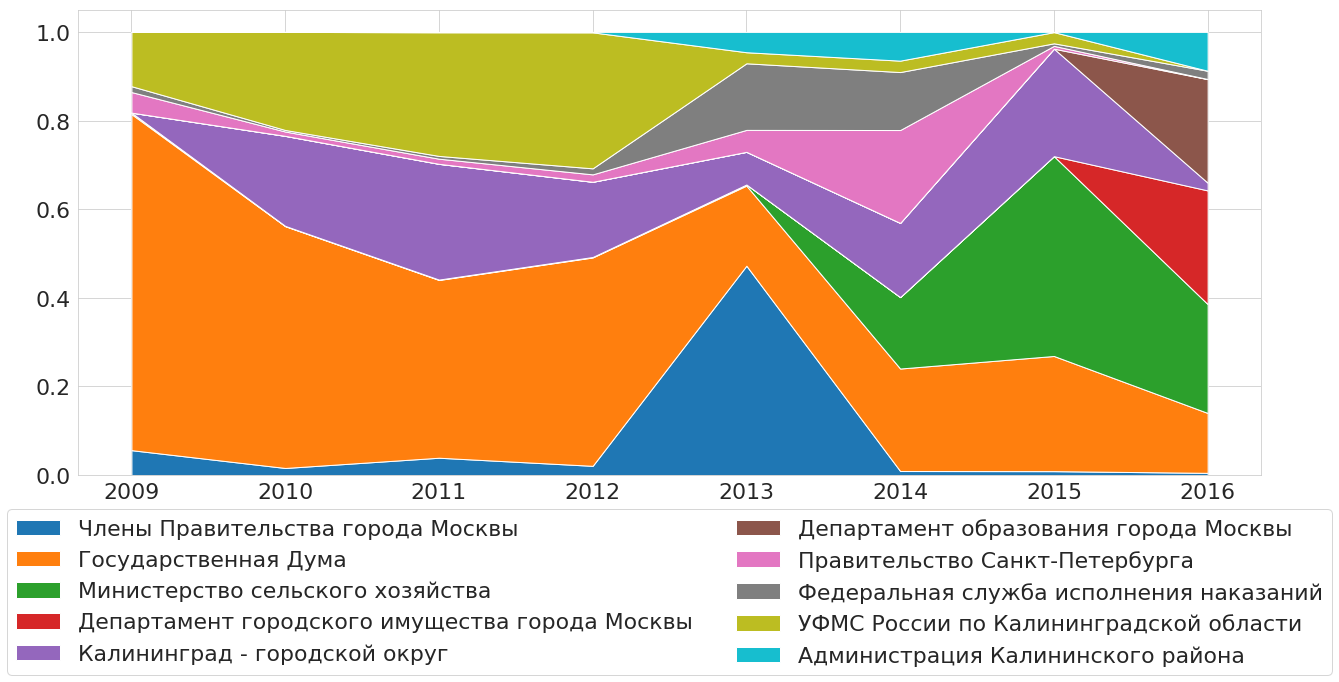

In [375]:
print('People per year per office')

years=sorted(declarations_df.year.unique())

top_offices = np.array(unique_per_office.head(10).index)


grouped = declarations_df.groupby(['office_id', 'year'])['person_id'].nunique()
grouped.head()
y = []
for office in top_offices:
    vals = grouped[office]
    vals = vals.reindex(years, fill_value=0)
    vals.name = office
    y.append(vals)
    
y = pd.DataFrame(y).T
y = y.divide(y.sum(axis=1), axis=0)
labels = office_names.ix[top_offices].values.flatten()
plt.figure(figsize=(20, 10))
plt.stackplot(years,y.T.values, labels=labels)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
save_pic('unique_by_year_by_office')
plt.show()

# Declared assets

In [ ]:

income_sum = declarations_df.groupby(['person_id'])['income'].sum()
print(income_sum.shape)
income_sum.head()

In [ ]:
income_sum = income_sum.sort_values(ascending=False)

In [ ]:
plt.figure(figsize=(15, 7))
sns.boxplot(income_sum)
save_pic('income_boxplot_1')
plt.show()

### Income
* Total income per year
* Median income per year
* Median income per office
* Top offices by median income, per year

In [ ]:
yearly_assets_sum = declarations_df.groupby(['year']).sum()
yearly_assets_sum.head()

In [ ]:
plt.figure(figsize=(15, 7))
plt.title('income total')
sns.barplot(yearly_assets_sum.index, yearly_assets_sum.income)
save_pic('income_by_years')
plt.show()

In [ ]:
yearly_assets_median = declarations_df.groupby(['year']).median()
yearly_assets_median.head()

In [ ]:
plt.figure(figsize=(15, 7))
plt.title('income median')
sns.barplot(yearly_assets_median.index, yearly_assets_median.income)
save_pic('income_by_years_med')
plt.show()   

In [ ]:
office_people_counts = declarations_df.groupby(['office_id'])['person_id'].count().sort_values(ascending=False)
big_offices = office_people_counts[office_people_counts > office_people_counts.quantile(0.75)] # over 35 people in office 
big_offices.shape

In [ ]:
big_office_declarations = declarations_df[declarations_df.office_id.isin(big_offices.index)]
print(big_office_declarations.shape)
big_office_declarations.head()

In [ ]:
# Total income per office
office_assets_sum = declarations_df.groupby(['office_name']).sum().sort_values(by='income', ascending=False)
office_assets_sum.head()
to_plot = pd.DataFrame(office_assets_sum.head(10).reset_index())
to_plot.loc[4, 'office_name'] = 'РОСТЕХ'
plt.figure(figsize=(20, 7))
plt.title('Top 10 offices by income, income total')
sns.barplot(y=to_plot.office_name, x=to_plot.income)
save_pic('office_incomes')
plt.show()

In [ ]:
# Total income per office, only big offices
office_assets_sum = big_office_declarations.groupby(['office_name']).sum().sort_values(by='income', ascending=False)
to_plot = pd.DataFrame(office_assets_sum.head(10).reset_index())
to_plot.loc[3, 'office_name'] = 'РОСТЕХ'
plt.figure(figsize=(20, 7))
plt.title('Top 10 big offices by income, income total')
sns.barplot(y=to_plot.office_name, x=to_plot.income)
save_pic('big_office_incomes')
plt.show()

In [ ]:
# Median income per office
office_assets_median = big_office_declarations.groupby(['office_name']).median().sort_values(by='income', ascending=False)
office_assets_median.head()

In [ ]:
to_plot = office_assets_median.head(20)
plt.figure(figsize=(25, 7))
plt.title('Top 20 offices by income, median')
sns.barplot(y=to_plot.index, x=to_plot.income)
plt.show()

Income per year per office


/home/boris/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


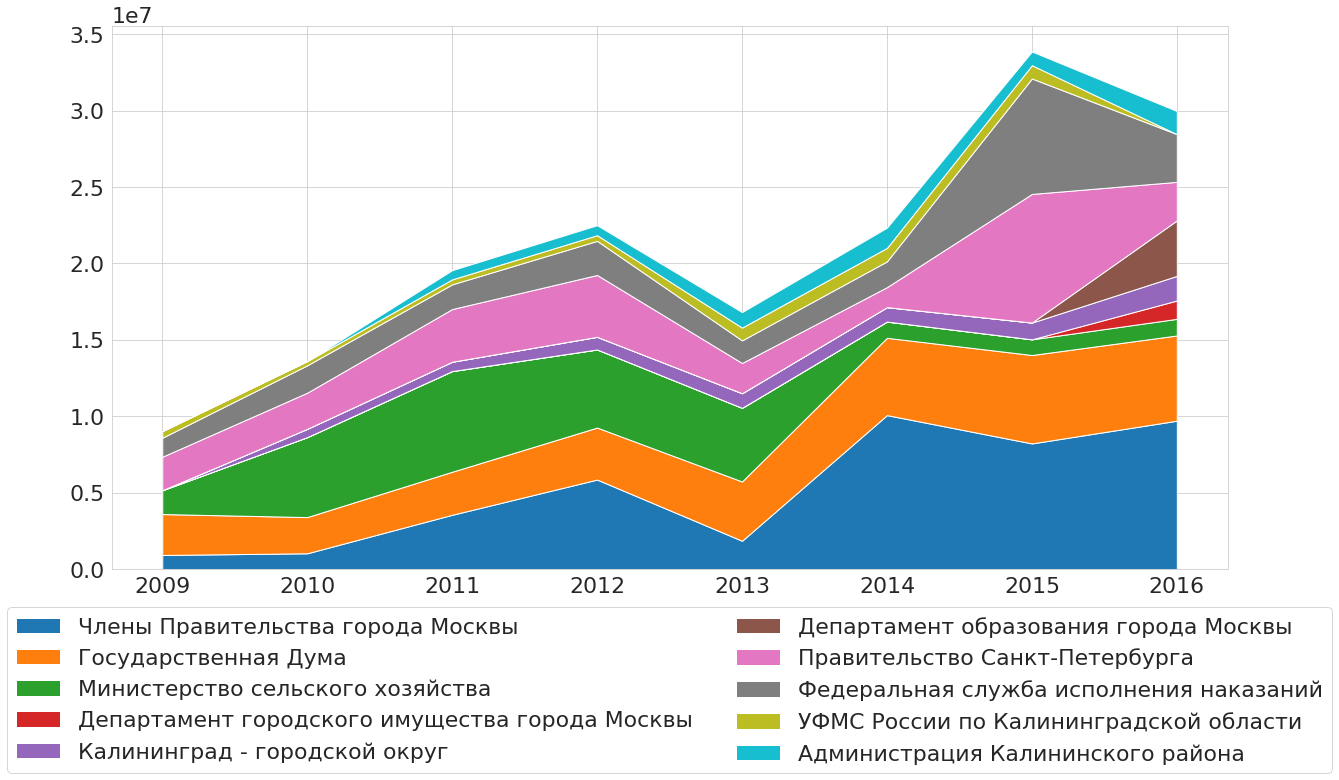

In [411]:
print('Income per year per office')

years=sorted(declarations_df.year.unique())

top_offices = np.array(unique_per_office.head(10).index)


grouped = declarations_df.groupby(['office_id', 'year'])['income'].median()
grouped.head()
# Incomes per year per office
y = []
for office in top_offices:
    vals = grouped[office]
    vals = vals.reindex(years, fill_value=0)
    vals.name = office
    y.append(vals)
    
labels = office_names.ix[top_offices].values.flatten()
plt.figure(figsize=(20, 10))
plt.stackplot(years,y, labels=labels)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
plt.show()

In [412]:
grouped.head()
g = grouped.reset_index()
g = g[g.office_id.isin(top_offices)]
g['office_name'] = office_names.ix[g.office_id].values.flatten()
g.head()

/home/boris/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


,office_id,year,income,office_name
56,14,2009,2676312.00,Государственная Дума
57,14,2010,2368195.14,Государственная Дума
58,14,2011,2815209.25,Государственная Дума
59,14,2012,3401201.53,Государственная Дума
60,14,2013,3876952.00,Государственная Дума


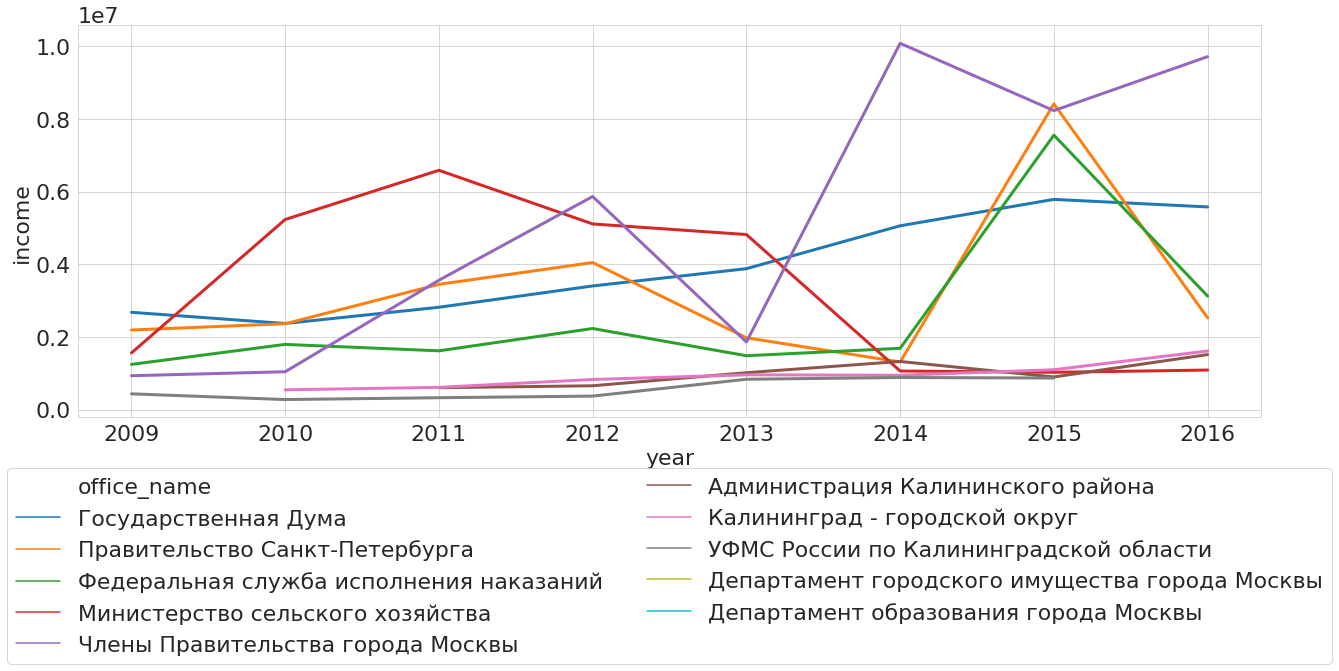

In [413]:
plt.figure(figsize=(20, 10))
sns.lineplot(x='year', y='income', hue='office_name', data=g, lw=3, markers=True, estimator=None)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
save_pic('income_by_year_by_office_med')
plt.show()

In [ ]:
# Median income per office in 2016
office_assets_median = big_office_declarations[big_office_declarations.year == 2016].groupby(['office_name']).median().sort_values(by='income', ascending=False)
office_assets_median.head()
to_plot = office_assets_median.head(10)
plt.figure(figsize=(20, 7))
plt.title('Top 10 offices by income, median, 2016')
sns.barplot(to_plot.index, to_plot.income)
plt.show()

In [ ]:
# Top offices by median income, by year
tdf= big_office_declarations.groupby(['year', 'office_name'])['income'].median().reset_index()
tdf2 = tdf.groupby('year')['income'].max().reset_index()
tdf_final = tdf.merge(tdf2, on=['year', 'income'], how='inner')
tdf_final.office_name = tdf_final.office_name.apply(lambda x: x.replace('\n', ' '))
plt.figure(figsize=(15,7))
plt.title('Top offices by median income, by year')
sns.barplot(x='year', y='income', hue='office_name', data=tdf_final)
plt.show()

### Income distributions
* Income percentile distributions

In [ ]:
percentiles = [0, 0.75, 0.95, 0.99, 0.9999, 1]
labels = ['p'+str(percentiles[i-1]) +' - ' +str(percentiles[i]) for i in range(1, len(percentiles))]
qcut, bins = pd.qcut(income_sum, percentiles, labels=labels, retbins=True)

In [ ]:
plt.figure(figsize=(20, 7))
plt.title('Percentile incomes, log scale (!)')
sns.barplot(labels, bins[1:])
plt.yscale('log')
save_pic('perc_inc_log')
plt.show()

In [ ]:
plt.figure(figsize=(20, 7))
plt.title('Amount of people with percentile incomes')
sns.countplot(qcut)
save_pic('perc_am_log')
plt.show()

In [ ]:
print('Total income')

plt.figure(figsize=(15, 15))

for i, percentile in enumerate(labels):
    plt.subplot(len(labels), 1, i+1)
    percentile_persons = qcut[qcut == percentile].index
    
    percentile_income = income_sum.loc[percentile_persons]
    
    plt.title(percentile +' income distribution')
    millions_xlabel = False
    if percentile_income.max() >= 1e6:
        percentile_income = percentile_income / 1e6
        millions_xlabel = True
    sns.boxplot(percentile_income, orient='h')
    # if millions_xlabel:
    #     plt.xlabel('income, million rub')
    plt.xlabel('')
save_pic('boxplots_perc')
plt.show()

In [ ]:
print('Median income')
for percentile in labels:
    percentile_persons = qcut[qcut == percentile].index
    
    percentile_income = income_sum.loc[percentile_persons]
    
    plt.figure()
    plt.title(percentile +' income distribution')
    millions_xlabel = False
    if percentile_income.min() >= 1e6:
        percentile_income = percentile_income / 1e6
        millions_xlabel = True
    sns.boxplot(percentile_income)
    if millions_xlabel:
        plt.xlabel('income, millions')
    plt.show()

In [ ]:
final_df = pd.DataFrame(index=range(1, 11))
for year in declarations_df.year.unique():
    tdf = declarations_df[declarations_df.year == year].groupby(['person_name'])['income'].sum().sort_values(ascending=False)
    top_10 = list(tdf.head(10).index)
    final_df[year] = top_10

print('Top 10 people by income, each year')
final_df

In [ ]:
years_worked = declarations_df.groupby(['person_id'])['year'].nunique()
years_worked.name = 'years worked'
years_worked.head()

In [ ]:
plt.figure()
sns.boxplot(years_worked)
plt.show()

In [ ]:
income = declarations_df.groupby(['person_id'])['income'].sum()
income = income.loc[years_worked.index]
plt.figure(figsize=(15, 7))
sns.lineplot(years_worked, income)
plt.show()

In [ ]:
# We can observe a log dependency
plt.figure(figsize=(15, 7))
sns.lineplot(years_worked, income)
plt.yscale('log')
plt.show()

In [ ]:
income_filtered = income[(income < income.mean()+2*income.std()) & (income > income.mean()-2*income.std())]
years_worked_filtered = years_worked.loc[income_filtered.index]
plt.figure(figsize=(15, 7))
plt.title("Income vs years worked, without outliers")
sns.lineplot(years_worked_filtered, income_filtered)
save_pic('income_vs_years')
plt.show()

In [ ]:
plt.figure(figsize=(15, 7))
plt.title("Income vs years worked, without outliers")
sns.scatterplot(years_worked_filtered, income_filtered)
plt.show()

In [ ]:

def clean_up_data(df):
    df = df[(df.year >= 2009) & (df.year <= 2016)]
    income = df.income
    df = df[(income < income.mean()+3*income.std()) & (income > income.mean()-3*income.std())]
    return df

